In [48]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, recall_score, precision_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
loans = pd.read_csv("loan_approval_dataset.csv")
loans.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
loans.columns = loans.columns.str.strip()
loans.drop("loan_id", axis=1, inplace=True)
loans.drop("cibil_score", axis=1, inplace=True) # Only consider 1st time applicants

loans['education'] = loans['education'].str.strip()
loans['self_employed'] = loans['self_employed'].str.strip()
loans['loan_status'] = loans['loan_status'].str.strip()

loans["education"] = loans["education"].replace({"Graduate" : 1, "Not Graduate" : 0})
loans["self_employed"] = loans["self_employed"].replace({"Yes" : 1, "No" : 0})
loans["loan_status"] = loans["loan_status"].replace({"Approved" : 1, "Rejected" : 0})

loans.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,12400000,8200000,29400000,5000000,0


In [4]:
X = loans.drop("loan_status", axis=1)
y = loans["loan_status"]

In [5]:
# Split training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.3)

# Comparing accuracies
accs_base = {"lr":0, "dtc":0, "rfc":0, "xgb":0}


In [6]:
# Base models
lr = LogisticRegression(random_state=1234)
dtc = DecisionTreeClassifier(random_state=1234)
rfc = RandomForestClassifier(random_state=1234)
xgb = XGBClassifier(random_state=1234)

## Unbalanced

In [7]:
accs_base["lr"] = cross_val_score(lr, X_train, y_train).mean()
accs_base["dtc"] = cross_val_score(dtc, X_train, y_train).mean()
accs_base["rfc"] = cross_val_score(rfc, X_train, y_train).mean()
accs_base["xgb"] = cross_val_score(xgb, X_train, y_train).mean()

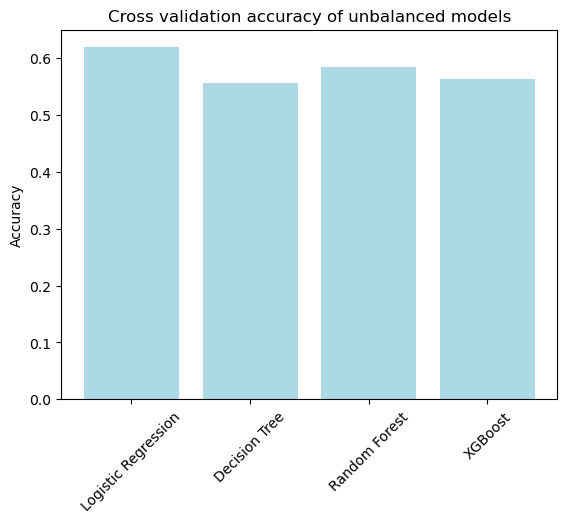

In [98]:
# Data from the accs_base dictionary
models = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
accuracies = list(accs_base.values())

# Create a bar graph with a blue color palette
plt.bar(models, accuracies, color='lightblue')

# Adding labels and title
plt.ylabel('Accuracy')
plt.title('Cross validation accuracy of unbalanced models')
plt.xticks(rotation=45)

# Display the bar graph
plt.show()


## Balanced

In [9]:
accs_bal = {"lr":0, "dtc":0, "rfc":0, "xgb":0}

In [10]:
# Balancing with smote
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [11]:
accs_bal["lr"] = cross_val_score(lr, X_train_smote, y_train_smote).mean()
accs_bal["dtc"] = cross_val_score(dtc, X_train_smote, y_train_smote).mean()
accs_bal["rfc"] = cross_val_score(rfc, X_train_smote, y_train_smote).mean()
accs_bal["xgb"] = cross_val_score(xgb, X_train_smote, y_train_smote).mean()

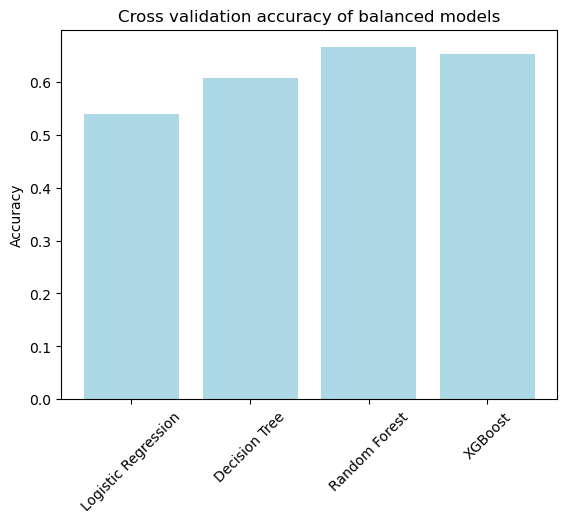

In [99]:
# Data from the accs_base dictionary
models = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
accuracies = list(accs_bal.values())

# Create a bar graph with a blue color palette
plt.bar(models, accuracies, color='lightblue')

# Adding labels and title
plt.ylabel('Accuracy')
plt.title('Cross validation accuracy of balanced models')
plt.xticks(rotation=45)

# Display the bar graph
plt.show()

## Feature selection

### RFC

In [13]:
# feature selection
rfc_sfs = SFS(
    RandomForestClassifier(),
    k_features=(1, X_train_smote.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
rfc_sfs.fit(X_train_smote, y_train_smote)

SequentialFeatureSelector(estimator=RandomForestClassifier(),
                          k_features=(1, 10), n_jobs=-1, scoring='accuracy')

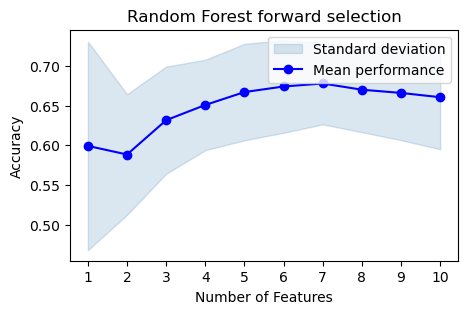

In [14]:
plot_sfs(rfc_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("Random Forest forward selection")
plt.legend(["Standard deviation", "Mean performance"])

In [15]:
rfc_features = list(rfc_sfs.get_metric_dict()[7]["feature_names"])
X_train_rfc = X_train_smote[rfc_features]
X_test_rfc = X_test[rfc_features]
y_train_rfc = y_train_smote

In [16]:
rfc = RandomForestClassifier()
rfc_sfs_model = rfc.fit(X_train_rfc, y_train_rfc)
y_pred_rfc = rfc_sfs_model.predict(X_test_rfc)

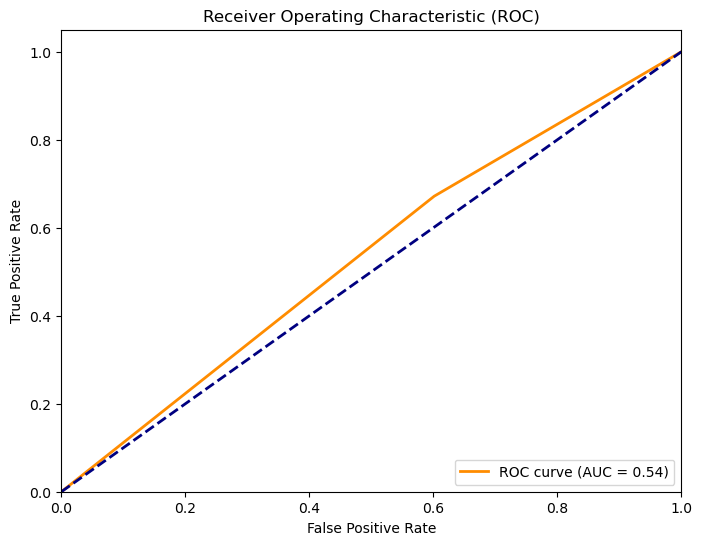

In [17]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rfc)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [18]:
print(accuracy_score(y_test, y_pred_rfc))
print(recall_score(y_test, y_pred_rfc))
print(precision_score(y_test, y_pred_rfc))

0.570647931303669
0.6716232961586122
0.6553808948004837


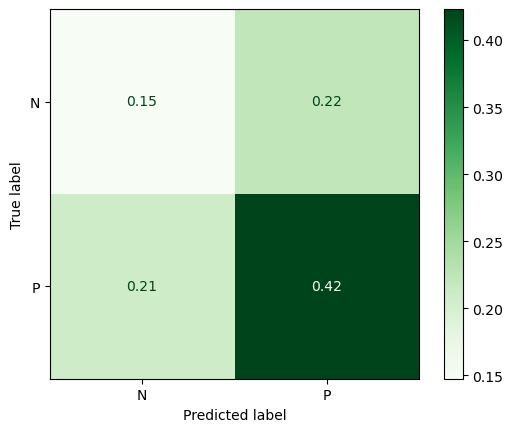

In [19]:
cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rfc, cmap="Greens", display_labels=["N", "P"], normalize="all")

### LR

In [20]:
# feature selection
lr_sfs = SFS(
    LogisticRegression(),
    k_features=(1, X_train.shape[1]),
    forward=True,
    scoring="accuracy",
    cv=5,
    verbose=0,
    n_jobs=-1
)
lr_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(), k_features=(1, 10),
                          n_jobs=-1, scoring='accuracy')

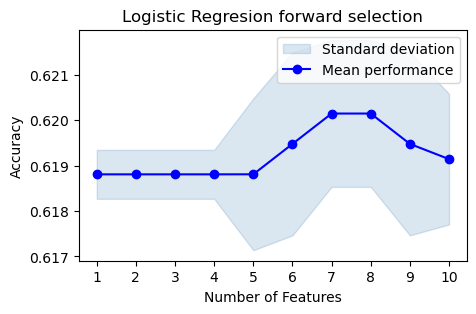

In [21]:
plot_sfs(lr_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
plt.title("Logistic Regresion forward selection")
plt.legend(["Standard deviation", "Mean performance"])

In [22]:
lr_features = list(lr_sfs.get_metric_dict()[7]["feature_names"])
X_train_lr = X_train[lr_features]
X_test_lr = X_test[lr_features]
y_train_lr = y_train

In [23]:
lr = LogisticRegression()
lr_sfs_model = rfc.fit(X_train_lr, y_train_lr)
y_pred_lr = lr_sfs_model.predict(X_test_lr)

In [24]:
rfc_sfs.get_metric_dict()[7]["feature_names"]

('income_annum',
 'loan_amount',
 'loan_term',
 'residential_assets_value',
 'commercial_assets_value',
 'luxury_assets_value',
 'bank_asset_value')

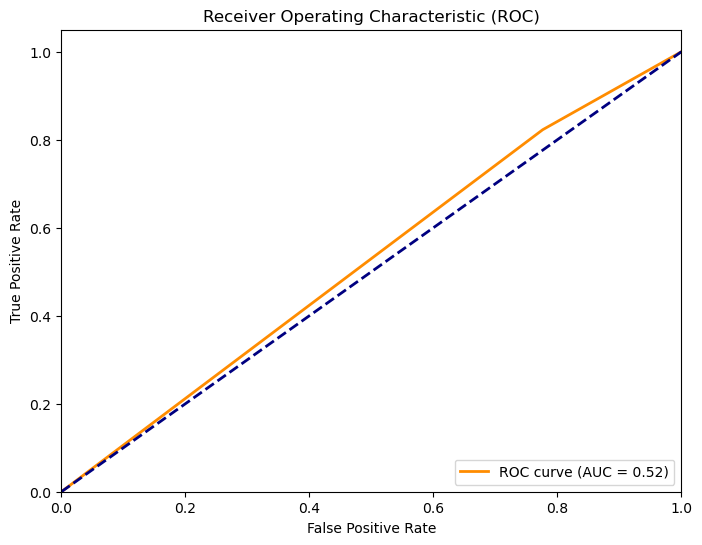

In [25]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [26]:
print(accuracy_score(y_test, # Data from the accs_base dictionary
models = ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"]
accuracies = list(accs_bal.values())

# Create a bar graph with a blue color palette
plt.bar(models, accuracies, color='lightblue')

# Adding labels and title
plt.ylabel('Accuracy')
plt.title('Accuracy of balanced models')
plt.xticks(rotation=45)

# Display the bar graph
plt.show()))
print(recall_score(y_test, y_pred_lr))
print(precision_score(y_test, y_pred_lr))

0.6010928961748634
0.8228004956629492
0.6434108527131783


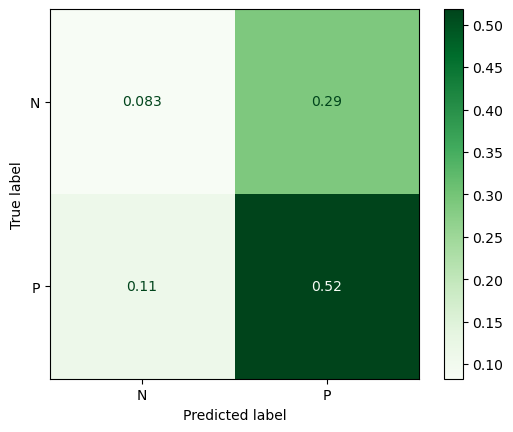

In [27]:
cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap="Greens", display_labels=["N", "P"], normalize="all")

## Hyper parameter tuning

### RFC

In [38]:
# Define the hyperparameter grid for grid search
param_grid = {
    'n_estimators': [175, 180, 185, 190],
    'max_depth': [None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2'],
    'criterion': ['gini'],
    'random_state': [1234],
    'class_weight':[{0: 1, 1: 9.0}],
    'random_state':[1234]
}

# Create GridSearchCV object
rfc_cv = GridSearchCV(
    estimator=RandomForestClassifier(), 
    param_grid=param_grid, 
    cv=5, 
    scoring="accuracy",
    refit=True, 
    n_jobs=-1, 
    verbose=1
)

# Fit the model to the training data
rfc_cv.fit(X_train_rfc, y_train_rfc)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters:  {'class_weight': {0: 1, 1: 9.0}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 180, 'random_state': 1234}
Best Score:  0.6728446037377024


In [54]:
# Retrieve the best parameters and best score
rfc_cv_best_params = rfc_cv.best_params_
rfc_cv_best_score = rfc_cv.best_score_

# Print the best parameters and best score
print("Best parameters:")
pp.pprint(rfc_cv_best_params)
print()
print("Best performance:")
print(rfc_cv_best_score)

Best parameters:
{   'class_weight': {0: 1, 1: 9.0},
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'log2',
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 180,
    'random_state': 1234}

Best performance:
0.6728446037377024


### LR

In [62]:
# Define the hyperparameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1],  
    'solver': ['liblinear'], 
    'class_weight':[None],
    "fit_intercept":[True, False],
    'max_iter':[500]
}

# Create GridSearchCV object
lr_cv = GridSearchCV(
    estimator=LogisticRegression(), 
    param_grid=param_grid, 
    cv=5, refit=True, 
    n_jobs=-1, 
    verbose=1, 
    scoring="accuracy"
)

# Fit the model to the training data
lr_cv.fit(X_train_lr, y_train_lr)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1], 'class_weight': [None],
                         'fit_intercept': [True, False], 'max_iter': [500],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy', verbose=1)

In [63]:
# Retrieve the best parameters and best score
lr_cv_best_params = lr_cv.best_params_
lr_cv_best_score = lr_cv.best_score_

# Print the best parameters and best score
print("Best parameters:")
pp.pprint(lr_cv_best_params)
print()
print("Best performance:")
print(lr_cv_best_score)

Best parameters:
{   'C': 0.001,
    'class_weight': None,
    'fit_intercept': True,
    'max_iter': 500,
    'penalty': 'l1',
    'solver': 'liblinear'}

Best performance:
0.6201481207598752


### Comparison of accuracy improvement

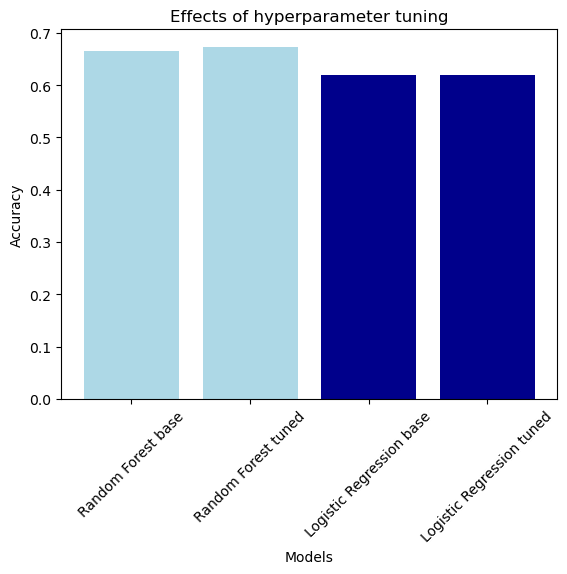

In [77]:
values = [accs_bal["rfc"], rfc_cv_best_score, accs_base["lr"], lr_cv_best_score]

# Create a list of colors for each pair of values
colors = ['lightblue', 'lightblue', 'darkblue', 'darkblue']

# Create labels for each bar
labels = ['Random Forest base', 'Random Forest tuned', 'Logistic Regression base', 'Logistic Regression tuned']

# Create a bar graph with customized colors
plt.bar(labels, values, color=colors)

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Effects of hyperparameter tuning')

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Display the bar graph
plt.show()

## Final evaluation

### RFC

In [40]:
y_pred_rfc_final = rfc_cv.predict(X_test_rfc)
print(f"acc: {accuracy_score(y_test, y_pred_rfc_final)}")
print(f"recall: {recall_score(y_test, y_pred_rfc_final)}")
print(f"precision: {precision_score(y_test, y_pred_rfc_final)}")

acc: 0.6026541764246682
recall: 0.8265179677819083
precision: 0.6438223938223938


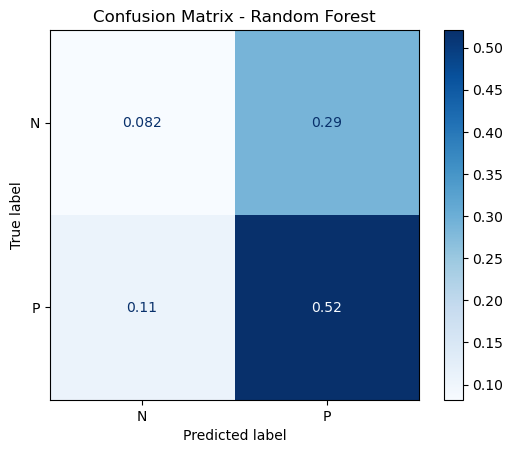

In [92]:
cmd_lr = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rfc_final, cmap="Blues", display_labels=["N", "P"], normalize="all")

# Set a title for the confusion matrix display
cmd_lr.ax_.set_title('Confusion Matrix - Random Forest')

# Display the confusion matrix
plt.show()

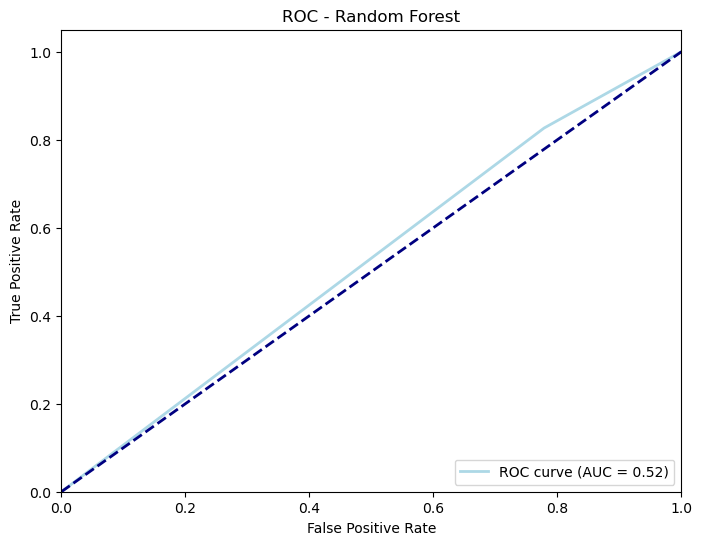

In [95]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rfc_final)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='lightblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()

### LR

In [79]:
y_pred_lr_final = lr_cv.predict(X_test_lr)
print(f"acc: {accuracy_score(y_test, y_pred_lr_final)}")
print(f"recall: {recall_score(y_test, y_pred_lr_final)}")
print(f"precision: {precision_score(y_test, y_pred_lr_final)}")

acc: 0.6315378610460578
recall: 1.0
precision: 0.6309616888193902


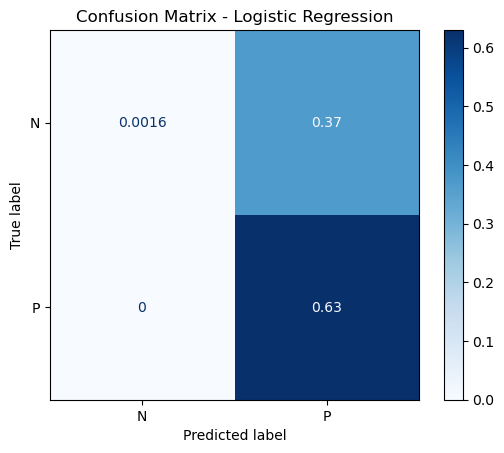

In [91]:
cmd_lr = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr_final, cmap="Blues", display_labels=["N", "P"], normalize="all")

# Set a title for the confusion matrix display
cmd_lr.ax_.set_title('Confusion Matrix - Logistic Regression')

# Display the confusion matrix
plt.show()

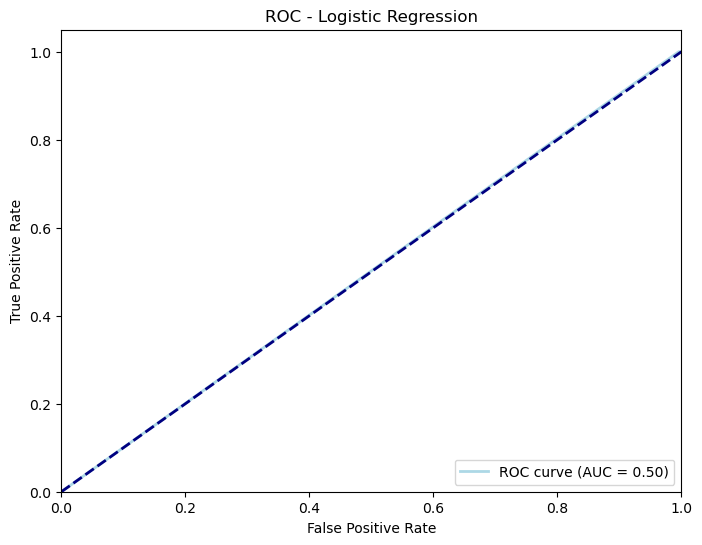

In [96]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr_final)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='lightblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [83]:
y_pred_lr_final.mean()

0.9984387197501952

In [84]:
y_pred_rfc_final.mean()

0.8087431693989071

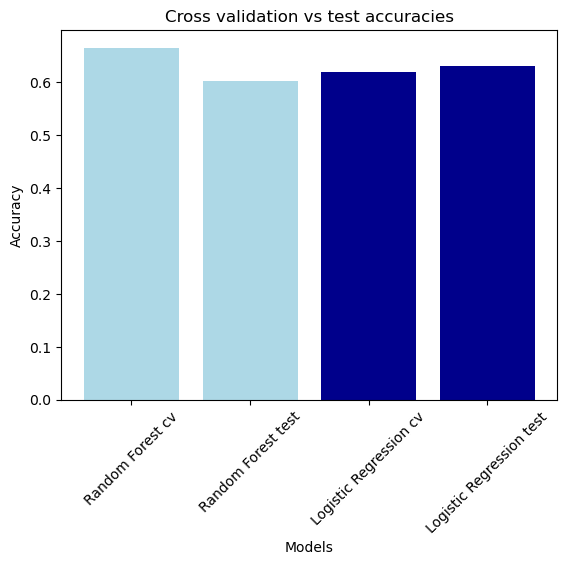

In [97]:
values = [accs_bal["rfc"], accuracy_score(y_test, y_pred_rfc_final), accs_base["lr"], accuracy_score(y_test, y_pred_lr_final)]

# Create a list of colors for each pair of values
colors = ['lightblue', 'lightblue', 'darkblue', 'darkblue']

# Create labels for each bar
labels = ['Random Forest cv', 'Random Forest test', 'Logistic Regression cv', 'Logistic Regression test']

# Create a bar graph with customized colors
plt.bar(labels, values, color=colors)

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Cross validation vs test accuracies')

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Display the bar graph
plt.show()